In [120]:
# Import libraries

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

In [121]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [122]:
# Get svhn dataset

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception('Data directory does not exist')
    
    
# Custom class to show download progress
class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile(data_dir + 'train_32x32.mat'):
    progressBar = DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN train dataset')
    urlretrieve(
        'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
        data_dir + 'train_32x32.mat',
        progressBar.hook
    )

if not isfile(data_dir + 'test_32x32.mat'):
    progressBar = DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN test dataset')
    urlretrieve(
        'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
        data_dir + 'test_32x32.mat',
        progressBar.hook
    )

In [123]:
# Load test and train set

train_set = loadmat(data_dir + 'train_32x32.mat')
test_set = loadmat(data_dir + 'test_32x32.mat')

In [124]:
idx = np.random.randint(0, train_set['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(train_set['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [125]:
# Scale images to match generator output

def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [126]:
# Split into test and validation sets

class Dataset():
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_index = int(len(test['y']) * (1 - val_frac))
        
        # Test and validation input set
        self.test_x = test['X'][:, :, :, :split_index]
        self.valid_x = test['X'][:, :, :, split_index:]
        
        # Test and validation labels set
        self.test_y = test['y'][:split_index]
        self.valid_y = test['y'][split_index:]
        
        # Train input and label sets
        self.train_x, self.train_y = train['X'], train['y']
        
        # Roll the specified axis backwards
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        # Scale
        self.scaler = scale_func if scale_func else scale
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            index = np.arange(len(dataset.train_x))
            np.random.shuffle(index)
            self.train_x = self.train_x[index]
            self.train_y = self.train_y[index]
        
        for i in range(0, len(self.train_y), batch_size):
            x = self.train_x[i: i + batch_size]
            y = self.train_y[i: i + batch_size]
            
            yield self.scaler(x), self.scaler(y)

In [127]:
# Model inputs

def model_inputs(discriminator_dim, generator_dim):
    input_discriminator = tf.placeholder(
        tf.float32,
        shape=[None, discriminator_dim[0], discriminator_dim[1], discriminator_dim[2]],
        name='input_discriminator'
    )
    inputs_generator = tf.placeholder(
        tf.float32, shape=[None, generator_dim],
        name='input_generator')
    
    return input_discriminator, inputs_generator

In [128]:
def generator(_input, output_dim, reuse=False, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        ## Fully connected layer
        fully = tf.layers.dense(_input, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        fully = tf.reshape(fully, (-1, 4, 4, 512))
        # Apply batch normalization
        fully = tf.layers.batch_normalization(fully, training=is_training)
        # Apply leaky relu
        fully = tf.maximum(alpha * fully, fully)
        
        ## First deconvolution
        conv_1 = tf.layers.conv2d_transpose(fully, 256, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_training)
        # Apply leaky relu
        conv_1 = tf.maximum(alpha * conv_1, conv_1)
        
        ## Second deconvolution
        conv_2 = tf.layers.conv2d_transpose(conv_1, 128, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_training)
        # Apply leaky relu
        conv_2 = tf.maximum(alpha * conv_2, conv_2)
        
        ## Output deconvolution layer
        
        logits = tf.layers.conv2d_transpose(conv_2, output_dim, 5, strides=2, padding='same')
        return tf.tanh(logits)

In [129]:
def discriminator(_input, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        ## First convolution
        conv_1 = tf.layers.conv2d(_input, 64, 5, strides=2, padding='same')
        # Apply leaky relu without batch normalization
        conv_1 = tf.maximum(alpha * conv_1, conv_1)
        
        ## Second convolution
        conv_2 = tf.layers.conv2d(conv_1, 128, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        # Apply leaky relu
        conv_2 = tf.maximum(alpha * conv_2, conv_2)
        
        ## Third convolution
        conv_3 = tf.layers.conv2d(conv_2, 256, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        # Apply leaky relu
        conv_3 = tf.maximum(alpha * conv_3, conv_3)
        
        ## Output fully connected layer and flatten it
        flat = tf.reshape(conv_3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [130]:
# Model loss

def model_loss(input_discriminator, input_generator, output_dim, alpha=0.2):
    ## Create genereator model
    generator_model = generator(
        input_generator,
        output_dim,
        alpha=alpha
    )
    
    ## Create discriminator real model
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_discriminator,
        alpha=alpha
    )
    
    ## Create discriminator fake model
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model,
        reuse=True,
        alpha=alpha
    )
    
    ## Get discriminator real loss
    discriminator_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real,
        labels=tf.ones_like(discriminator_model_real)
    )
    discriminator_loss_real = tf.reduce_mean(discriminator_loss_real)
    
    ## Get discriminator fake loss
    discriminator_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake,
        labels=tf.zeros_like(discriminator_model_fake)
    )
    discriminator_loss_fake = tf.reduce_mean(discriminator_loss_fake)
    
    ## Add discriminator losses
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    ## Get generator loss
    generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake,
        labels=tf.ones_like(discriminator_model_fake)
    )
    generator_loss = tf.reduce_mean(generator_loss)
    
    return discriminator_loss, generator_loss

In [131]:
# Optimizers

def model_optimizers(discriminator_loss, generator_loss, learning_rate, beta):
    ## Split trainable vars into generator and discriminator vars
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    ## Optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta
        ).minimize(discriminator_loss, var_list=discriminator_vars)
        
        generator_train = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta
        ).minimize(generator_loss, var_list=generator_vars)
    
    return discriminator_train, generator_train

In [132]:
# Build the model

class GAN:
    def __init__(self, discriminator_size, generator_size, learning_rate, alpha=0.2, beta=0.5):
        tf.reset_default_graph()
        
        self.input_discriminator, self.input_generator = model_inputs(
            discriminator_size,
            generator_size
        )
        
        self.discriminator_loss, self.generator_loss = model_loss(
            self.input_discriminator,
            self.input_generator,
            discriminator_size[2],
            alpha=alpha
        )
        
        self.discriminator_optimizer, self.generator_optimizer = model_optimizers(
            self.discriminator_loss,
            self.generator_loss,
            learning_rate,
            beta
        )

In [133]:
# Function to display generated images

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [134]:
# Training

def train(network, dataset, epochs, batch_size, print_every=10, show_every=100, fig_size=(5,5)):
    saver = tf.train.Saver()
    sample_generator = np.random.uniform(-1, 1, size=(72, generator_size))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                # Sample random noise for Generator
                batch_generator = np.random.uniform(-1, 1, size=(batch_size, generator_size))
                
                
                # Run optimizers
                feed_dict = {
                    network.input_discriminator: x,
                    network.input_generator: batch_generator
                }

                session.run(
                    network.discriminator_optimizer,
                    feed_dict=feed_dict
                )
                
                session.run(
                    network.generator_optimizer,
                    feed_dict=feed_dict
                )
                
                if steps % print_every == 0:
                    # Print losses at the end of each epoch
                    
                    train_loss_discriminator = network.discriminator_loss.eval(feed_dict)
                    train_loss_generator = network.generator_loss.eval({network.input_generator: batch_generator})
                    
                    print("Epoch {}/{}...".format(epoch + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator))
                    
                    # Save losses to view after training
                    losses.append((train_loss_discriminator, train_loss_generator))
                    
                if steps % show_every == 0:
                    generator_samples = session.run(
                        generator(network.input_generator, 3, reuse=True, is_training=False),
                        feed_dict={network.input_generator: sample_generator}
                    )
                    samples.append(generator_samples)
                    view_samples(-1, samples, 6, 12, figsize=fig_size)
                    plt.show()
        
        saver.save(session, './checkpoints/generator.ckpt')
        
    with open('samples.pkl', 'wb') as _file:
        pkl.dump(samples, _file)
        
    return losses, samples

In [ ]:

discriminator_size = (32,32,3)
generator_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(discriminator_size, generator_size, learning_rate, alpha=alpha, beta=beta1)

Epoch 1/25... Discriminator Loss: 1.0343... Generator Loss: 0.7890
Epoch 1/25... Discriminator Loss: 0.3562... Generator Loss: 1.9327
Epoch 1/25... Discriminator Loss: 0.1597... Generator Loss: 2.5494
Epoch 1/25... Discriminator Loss: 0.1189... Generator Loss: 3.2055
Epoch 1/25... Discriminator Loss: 0.1742... Generator Loss: 2.4365
Epoch 1/25... Discriminator Loss: 0.0932... Generator Loss: 3.0809
Epoch 1/25... Discriminator Loss: 0.1086... Generator Loss: 2.9918
Epoch 1/25... Discriminator Loss: 0.1514... Generator Loss: 3.5993
Epoch 1/25... Discriminator Loss: 0.1516... Generator Loss: 3.3088
Epoch 1/25... Discriminator Loss: 0.1578... Generator Loss: 3.5184


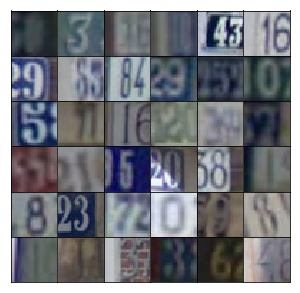

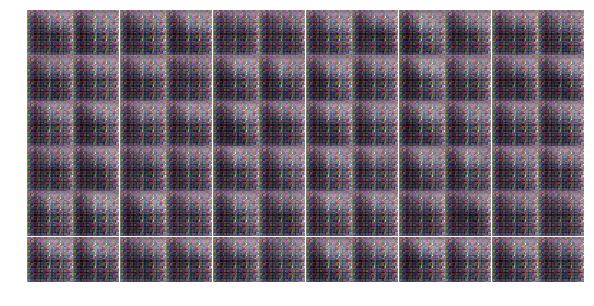

Epoch 1/25... Discriminator Loss: 0.1364... Generator Loss: 3.3000
Epoch 1/25... Discriminator Loss: 0.7190... Generator Loss: 1.9629
Epoch 1/25... Discriminator Loss: 0.7275... Generator Loss: 3.1553
Epoch 1/25... Discriminator Loss: 0.4240... Generator Loss: 1.7471
Epoch 1/25... Discriminator Loss: 0.8823... Generator Loss: 1.9317
Epoch 1/25... Discriminator Loss: 0.3656... Generator Loss: 2.4639
Epoch 1/25... Discriminator Loss: 0.2591... Generator Loss: 2.5696
Epoch 1/25... Discriminator Loss: 0.5282... Generator Loss: 2.7835
Epoch 1/25... Discriminator Loss: 0.8575... Generator Loss: 0.9037
Epoch 1/25... Discriminator Loss: 0.2446... Generator Loss: 2.7797


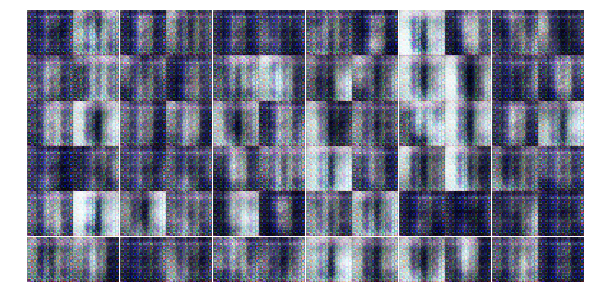

Epoch 1/25... Discriminator Loss: 1.1196... Generator Loss: 0.7014
Epoch 1/25... Discriminator Loss: 0.2402... Generator Loss: 2.2640
Epoch 1/25... Discriminator Loss: 0.7350... Generator Loss: 1.8390
Epoch 1/25... Discriminator Loss: 0.2687... Generator Loss: 2.2494
Epoch 1/25... Discriminator Loss: 0.3904... Generator Loss: 1.3937
Epoch 1/25... Discriminator Loss: 0.1839... Generator Loss: 4.1872
Epoch 1/25... Discriminator Loss: 0.2844... Generator Loss: 2.0502
Epoch 1/25... Discriminator Loss: 1.2363... Generator Loss: 0.8487
Epoch 1/25... Discriminator Loss: 0.7599... Generator Loss: 2.4371
Epoch 1/25... Discriminator Loss: 0.2887... Generator Loss: 1.9291


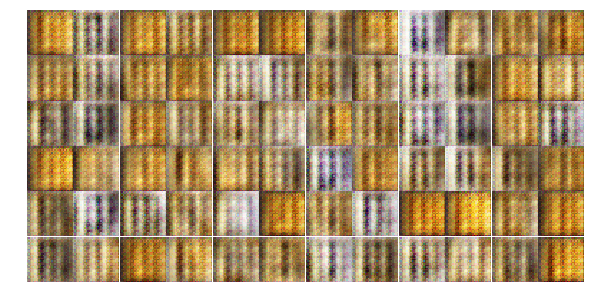

Epoch 1/25... Discriminator Loss: 1.2042... Generator Loss: 0.6819
Epoch 1/25... Discriminator Loss: 0.8312... Generator Loss: 1.5944
Epoch 1/25... Discriminator Loss: 0.8213... Generator Loss: 1.0764
Epoch 1/25... Discriminator Loss: 0.7952... Generator Loss: 1.3376
Epoch 1/25... Discriminator Loss: 0.5226... Generator Loss: 1.5167
Epoch 1/25... Discriminator Loss: 0.5467... Generator Loss: 1.6726
Epoch 1/25... Discriminator Loss: 0.5051... Generator Loss: 1.9166
Epoch 1/25... Discriminator Loss: 0.4114... Generator Loss: 1.9150
Epoch 1/25... Discriminator Loss: 0.5412... Generator Loss: 1.6289
Epoch 1/25... Discriminator Loss: 0.7386... Generator Loss: 2.2469


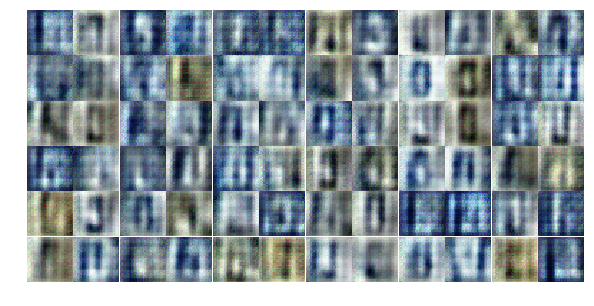

Epoch 1/25... Discriminator Loss: 0.6378... Generator Loss: 2.0303
Epoch 1/25... Discriminator Loss: 0.7710... Generator Loss: 1.0445
Epoch 1/25... Discriminator Loss: 0.6907... Generator Loss: 1.4960
Epoch 1/25... Discriminator Loss: 0.9417... Generator Loss: 1.1595
Epoch 1/25... Discriminator Loss: 1.2615... Generator Loss: 0.5923
Epoch 1/25... Discriminator Loss: 0.7519... Generator Loss: 0.9644
Epoch 1/25... Discriminator Loss: 0.8079... Generator Loss: 0.9980
Epoch 1/25... Discriminator Loss: 0.6699... Generator Loss: 1.4495
Epoch 1/25... Discriminator Loss: 1.0599... Generator Loss: 0.7895
Epoch 1/25... Discriminator Loss: 1.0029... Generator Loss: 1.0623


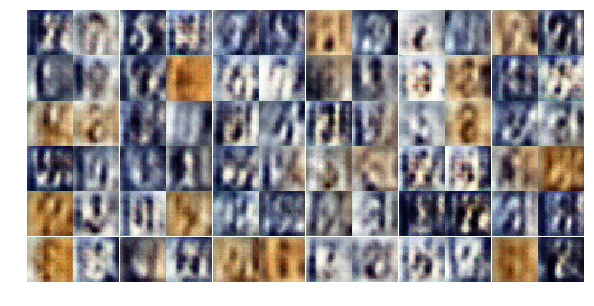

Epoch 1/25... Discriminator Loss: 0.8343... Generator Loss: 1.1359
Epoch 1/25... Discriminator Loss: 0.9600... Generator Loss: 0.8788
Epoch 1/25... Discriminator Loss: 0.6094... Generator Loss: 1.2730
Epoch 1/25... Discriminator Loss: 0.8628... Generator Loss: 0.9898
Epoch 1/25... Discriminator Loss: 0.7242... Generator Loss: 1.9858
Epoch 1/25... Discriminator Loss: 0.8460... Generator Loss: 1.0479
Epoch 1/25... Discriminator Loss: 0.6327... Generator Loss: 1.6559
Epoch 2/25... Discriminator Loss: 0.8819... Generator Loss: 1.2979
Epoch 2/25... Discriminator Loss: 1.0064... Generator Loss: 1.3396
Epoch 2/25... Discriminator Loss: 1.2864... Generator Loss: 0.9895


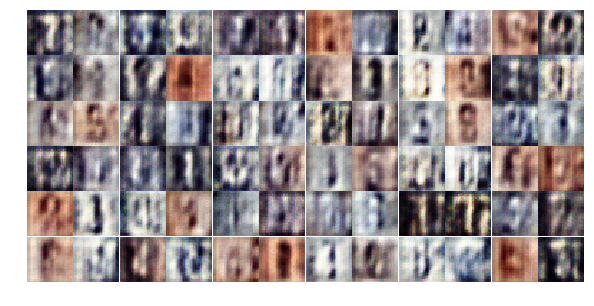

Epoch 2/25... Discriminator Loss: 0.9828... Generator Loss: 0.9797
Epoch 2/25... Discriminator Loss: 0.9450... Generator Loss: 1.6977
Epoch 2/25... Discriminator Loss: 1.4054... Generator Loss: 0.7393
Epoch 2/25... Discriminator Loss: 1.0888... Generator Loss: 1.2199
Epoch 2/25... Discriminator Loss: 0.8726... Generator Loss: 1.1473
Epoch 2/25... Discriminator Loss: 1.0548... Generator Loss: 0.8667
Epoch 2/25... Discriminator Loss: 1.1617... Generator Loss: 0.7385
Epoch 2/25... Discriminator Loss: 0.9952... Generator Loss: 0.9156
Epoch 2/25... Discriminator Loss: 1.0968... Generator Loss: 0.8407
Epoch 2/25... Discriminator Loss: 0.7732... Generator Loss: 1.4369


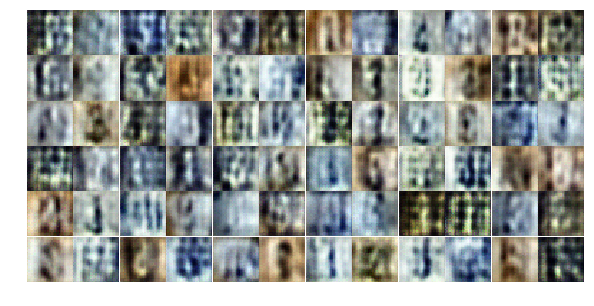

Epoch 2/25... Discriminator Loss: 1.2445... Generator Loss: 0.6741
Epoch 2/25... Discriminator Loss: 1.1433... Generator Loss: 0.9317
Epoch 2/25... Discriminator Loss: 1.7128... Generator Loss: 0.5181
Epoch 2/25... Discriminator Loss: 0.9999... Generator Loss: 0.8583
Epoch 2/25... Discriminator Loss: 1.1160... Generator Loss: 1.1495
Epoch 2/25... Discriminator Loss: 1.4523... Generator Loss: 0.7512
Epoch 2/25... Discriminator Loss: 1.1311... Generator Loss: 0.8037
Epoch 2/25... Discriminator Loss: 1.1033... Generator Loss: 0.7937
Epoch 2/25... Discriminator Loss: 1.2508... Generator Loss: 1.0286
Epoch 2/25... Discriminator Loss: 1.2802... Generator Loss: 0.7408


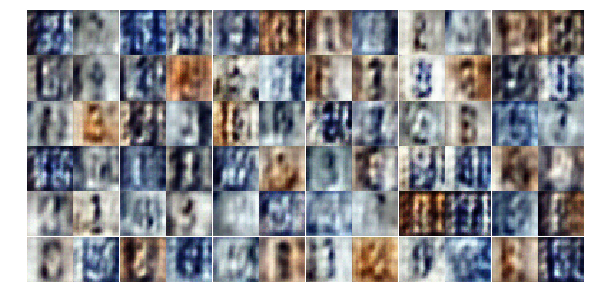

Epoch 2/25... Discriminator Loss: 1.0614... Generator Loss: 0.8045
Epoch 2/25... Discriminator Loss: 1.0429... Generator Loss: 0.9771
Epoch 2/25... Discriminator Loss: 1.0608... Generator Loss: 1.0367
Epoch 2/25... Discriminator Loss: 0.8936... Generator Loss: 0.9974
Epoch 2/25... Discriminator Loss: 1.2313... Generator Loss: 0.9949
Epoch 2/25... Discriminator Loss: 1.2646... Generator Loss: 0.7504
Epoch 2/25... Discriminator Loss: 1.0103... Generator Loss: 0.9250
Epoch 2/25... Discriminator Loss: 1.0861... Generator Loss: 0.8415
Epoch 2/25... Discriminator Loss: 1.0067... Generator Loss: 0.9298
Epoch 2/25... Discriminator Loss: 0.8863... Generator Loss: 1.2490


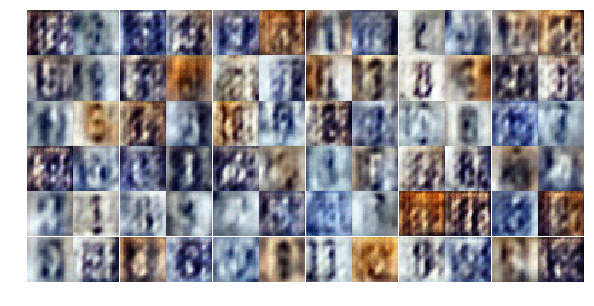

Epoch 2/25... Discriminator Loss: 1.1347... Generator Loss: 0.8937
Epoch 2/25... Discriminator Loss: 1.1731... Generator Loss: 0.8393
Epoch 2/25... Discriminator Loss: 1.1860... Generator Loss: 0.8609
Epoch 2/25... Discriminator Loss: 1.2538... Generator Loss: 0.6028
Epoch 2/25... Discriminator Loss: 1.1463... Generator Loss: 1.2283
Epoch 2/25... Discriminator Loss: 1.4788... Generator Loss: 0.6886
Epoch 2/25... Discriminator Loss: 1.4004... Generator Loss: 0.5986
Epoch 2/25... Discriminator Loss: 1.3405... Generator Loss: 0.7670
Epoch 2/25... Discriminator Loss: 1.4110... Generator Loss: 0.7238
Epoch 2/25... Discriminator Loss: 1.1211... Generator Loss: 1.2917


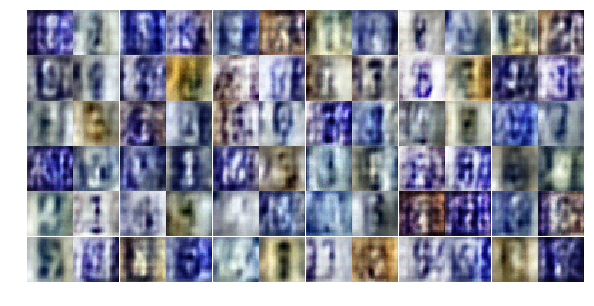

Epoch 2/25... Discriminator Loss: 1.2215... Generator Loss: 1.0240
Epoch 2/25... Discriminator Loss: 1.2002... Generator Loss: 0.7783
Epoch 2/25... Discriminator Loss: 1.0688... Generator Loss: 1.1131
Epoch 2/25... Discriminator Loss: 1.5300... Generator Loss: 0.5008
Epoch 2/25... Discriminator Loss: 1.5026... Generator Loss: 0.7158
Epoch 2/25... Discriminator Loss: 1.0744... Generator Loss: 0.9659
Epoch 2/25... Discriminator Loss: 1.1319... Generator Loss: 1.0756
Epoch 2/25... Discriminator Loss: 1.1959... Generator Loss: 1.2397
Epoch 2/25... Discriminator Loss: 0.9610... Generator Loss: 0.9243
Epoch 2/25... Discriminator Loss: 1.0109... Generator Loss: 0.9948


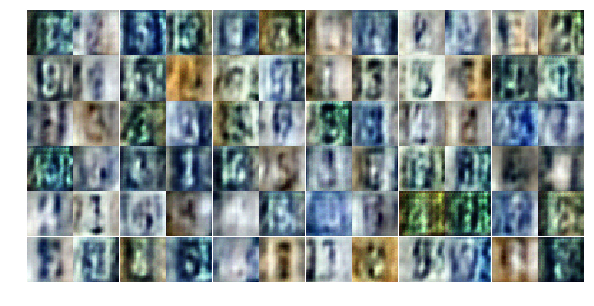

Epoch 2/25... Discriminator Loss: 0.8941... Generator Loss: 1.1971
Epoch 2/25... Discriminator Loss: 0.9621... Generator Loss: 1.0525
Epoch 2/25... Discriminator Loss: 1.1578... Generator Loss: 0.6819
Epoch 2/25... Discriminator Loss: 1.0957... Generator Loss: 0.8456
Epoch 3/25... Discriminator Loss: 1.1466... Generator Loss: 1.3445
Epoch 3/25... Discriminator Loss: 0.7971... Generator Loss: 1.0676
Epoch 3/25... Discriminator Loss: 1.0234... Generator Loss: 1.0639
Epoch 3/25... Discriminator Loss: 0.8459... Generator Loss: 1.0211
Epoch 3/25... Discriminator Loss: 0.8991... Generator Loss: 0.9773
Epoch 3/25... Discriminator Loss: 0.8319... Generator Loss: 1.1371


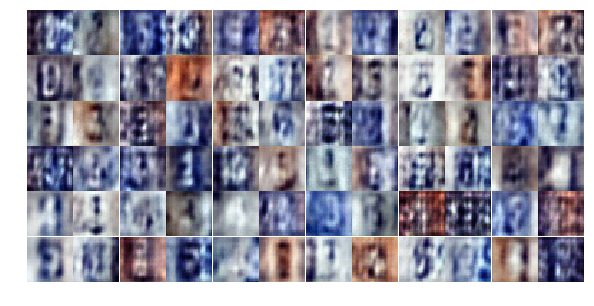

Epoch 3/25... Discriminator Loss: 0.8471... Generator Loss: 1.2033
Epoch 3/25... Discriminator Loss: 0.7403... Generator Loss: 1.0070
Epoch 3/25... Discriminator Loss: 0.8398... Generator Loss: 1.4043
Epoch 3/25... Discriminator Loss: 1.0474... Generator Loss: 0.9476
Epoch 3/25... Discriminator Loss: 0.6303... Generator Loss: 1.4787
Epoch 3/25... Discriminator Loss: 1.1928... Generator Loss: 0.7062
Epoch 3/25... Discriminator Loss: 0.4520... Generator Loss: 1.5069
Epoch 3/25... Discriminator Loss: 0.8051... Generator Loss: 1.4613
Epoch 3/25... Discriminator Loss: 1.7834... Generator Loss: 0.2878
Epoch 3/25... Discriminator Loss: 1.3548... Generator Loss: 0.5395


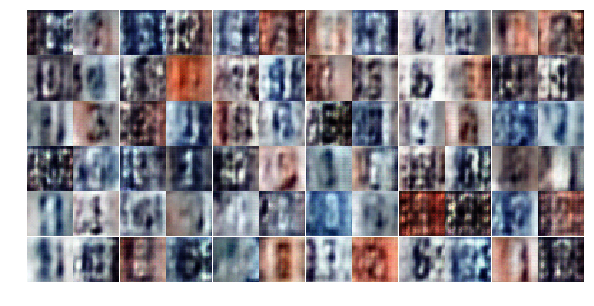

Epoch 3/25... Discriminator Loss: 1.0847... Generator Loss: 2.1473
Epoch 3/25... Discriminator Loss: 0.8267... Generator Loss: 1.1875
Epoch 3/25... Discriminator Loss: 1.3329... Generator Loss: 0.4991
Epoch 3/25... Discriminator Loss: 1.0275... Generator Loss: 1.1921
Epoch 3/25... Discriminator Loss: 0.9068... Generator Loss: 0.9529
Epoch 3/25... Discriminator Loss: 0.3933... Generator Loss: 2.2813
Epoch 3/25... Discriminator Loss: 1.1304... Generator Loss: 1.8526
Epoch 3/25... Discriminator Loss: 0.8430... Generator Loss: 0.9617
Epoch 3/25... Discriminator Loss: 0.7413... Generator Loss: 1.4425
Epoch 3/25... Discriminator Loss: 0.9331... Generator Loss: 0.8538


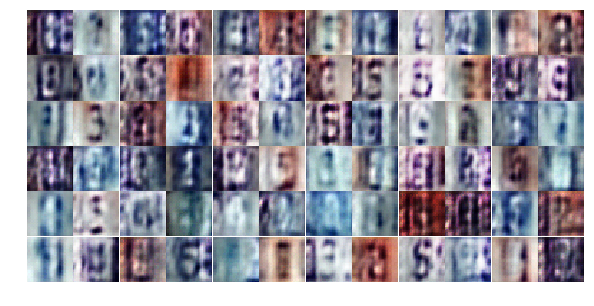

Epoch 3/25... Discriminator Loss: 0.7816... Generator Loss: 2.1429
Epoch 3/25... Discriminator Loss: 0.7805... Generator Loss: 1.1394
Epoch 3/25... Discriminator Loss: 0.7986... Generator Loss: 1.0233
Epoch 3/25... Discriminator Loss: 0.4956... Generator Loss: 1.3556
Epoch 3/25... Discriminator Loss: 0.6536... Generator Loss: 1.1612
Epoch 3/25... Discriminator Loss: 1.0926... Generator Loss: 0.6630
Epoch 3/25... Discriminator Loss: 0.9597... Generator Loss: 0.8888
Epoch 3/25... Discriminator Loss: 0.6625... Generator Loss: 1.2544
Epoch 3/25... Discriminator Loss: 0.7722... Generator Loss: 1.1344
Epoch 3/25... Discriminator Loss: 0.5853... Generator Loss: 1.1655


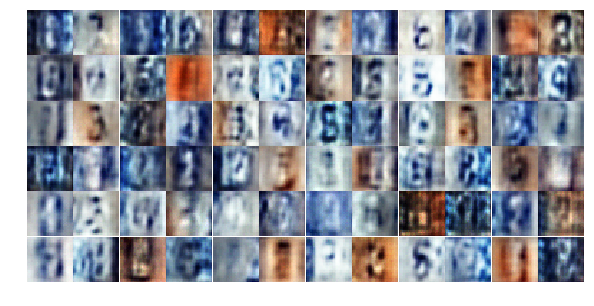

Epoch 3/25... Discriminator Loss: 1.1142... Generator Loss: 1.4434
Epoch 3/25... Discriminator Loss: 0.3477... Generator Loss: 2.2706
Epoch 3/25... Discriminator Loss: 0.5367... Generator Loss: 1.6585
Epoch 3/25... Discriminator Loss: 0.5803... Generator Loss: 1.3536
Epoch 3/25... Discriminator Loss: 0.9054... Generator Loss: 0.7063
Epoch 3/25... Discriminator Loss: 0.8176... Generator Loss: 0.8509
Epoch 3/25... Discriminator Loss: 1.1455... Generator Loss: 1.4872
Epoch 3/25... Discriminator Loss: 0.5949... Generator Loss: 1.6434
Epoch 3/25... Discriminator Loss: 1.0421... Generator Loss: 0.7087
Epoch 3/25... Discriminator Loss: 0.7444... Generator Loss: 1.1012


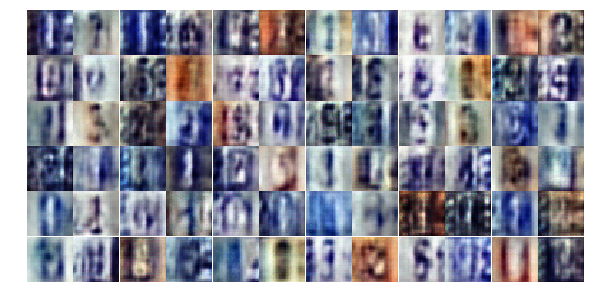

Epoch 3/25... Discriminator Loss: 0.6373... Generator Loss: 1.2990
Epoch 3/25... Discriminator Loss: 0.8449... Generator Loss: 0.9912
Epoch 3/25... Discriminator Loss: 0.3408... Generator Loss: 2.0499
Epoch 3/25... Discriminator Loss: 0.5369... Generator Loss: 1.6929
Epoch 3/25... Discriminator Loss: 1.6653... Generator Loss: 3.7142
Epoch 3/25... Discriminator Loss: 0.8127... Generator Loss: 1.4539
Epoch 3/25... Discriminator Loss: 0.9048... Generator Loss: 1.1326
Epoch 3/25... Discriminator Loss: 0.5372... Generator Loss: 1.7532
Epoch 3/25... Discriminator Loss: 0.6446... Generator Loss: 1.1433
Epoch 3/25... Discriminator Loss: 0.6014... Generator Loss: 1.3185


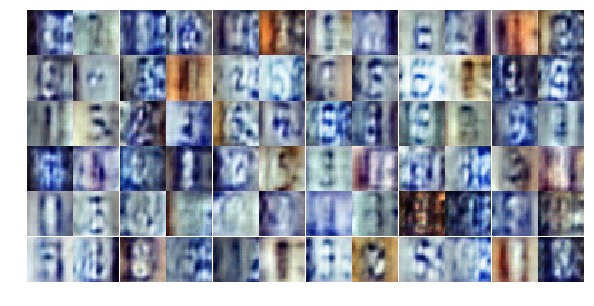

Epoch 3/25... Discriminator Loss: 1.7507... Generator Loss: 0.2891
Epoch 4/25... Discriminator Loss: 0.9541... Generator Loss: 0.8967
Epoch 4/25... Discriminator Loss: 0.9949... Generator Loss: 0.9197
Epoch 4/25... Discriminator Loss: 0.7932... Generator Loss: 1.0913
Epoch 4/25... Discriminator Loss: 0.6717... Generator Loss: 1.1791
Epoch 4/25... Discriminator Loss: 0.7105... Generator Loss: 1.7097
Epoch 4/25... Discriminator Loss: 1.1053... Generator Loss: 0.8378
Epoch 4/25... Discriminator Loss: 0.8623... Generator Loss: 1.3593
Epoch 4/25... Discriminator Loss: 0.6798... Generator Loss: 1.1343
Epoch 4/25... Discriminator Loss: 0.7862... Generator Loss: 0.9029


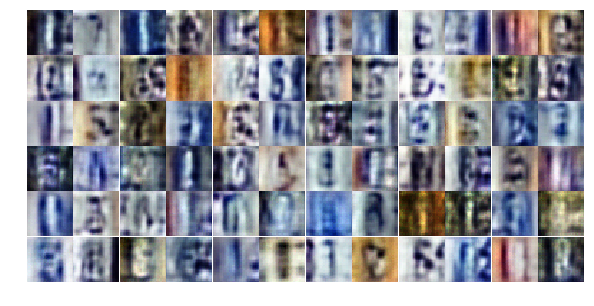

Epoch 4/25... Discriminator Loss: 0.6382... Generator Loss: 1.4591
Epoch 4/25... Discriminator Loss: 1.4490... Generator Loss: 0.3801
Epoch 4/25... Discriminator Loss: 1.0601... Generator Loss: 0.9032
Epoch 4/25... Discriminator Loss: 0.9305... Generator Loss: 0.8531
Epoch 4/25... Discriminator Loss: 0.9791... Generator Loss: 1.7685
Epoch 4/25... Discriminator Loss: 1.3786... Generator Loss: 0.4323
Epoch 4/25... Discriminator Loss: 0.8050... Generator Loss: 1.2799
Epoch 4/25... Discriminator Loss: 0.6401... Generator Loss: 1.3835
Epoch 4/25... Discriminator Loss: 1.1807... Generator Loss: 0.6029
Epoch 4/25... Discriminator Loss: 0.7541... Generator Loss: 1.5036


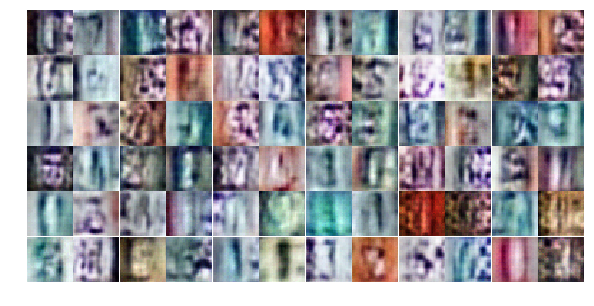

Epoch 4/25... Discriminator Loss: 0.7485... Generator Loss: 1.0219
Epoch 4/25... Discriminator Loss: 0.7338... Generator Loss: 1.7650
Epoch 4/25... Discriminator Loss: 0.7723... Generator Loss: 1.2394
Epoch 4/25... Discriminator Loss: 1.6317... Generator Loss: 2.8933
Epoch 4/25... Discriminator Loss: 0.7479... Generator Loss: 1.4578
Epoch 4/25... Discriminator Loss: 0.5052... Generator Loss: 1.7249
Epoch 4/25... Discriminator Loss: 1.4484... Generator Loss: 0.3412
Epoch 4/25... Discriminator Loss: 1.0005... Generator Loss: 0.8473
Epoch 4/25... Discriminator Loss: 0.6340... Generator Loss: 1.3830
Epoch 4/25... Discriminator Loss: 0.6234... Generator Loss: 1.7230


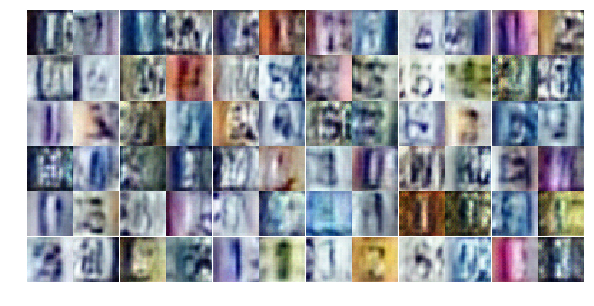

Epoch 4/25... Discriminator Loss: 0.6708... Generator Loss: 1.1992
Epoch 4/25... Discriminator Loss: 0.7634... Generator Loss: 0.9878
Epoch 4/25... Discriminator Loss: 0.7488... Generator Loss: 1.1473
Epoch 4/25... Discriminator Loss: 0.5272... Generator Loss: 2.0966
Epoch 4/25... Discriminator Loss: 0.4409... Generator Loss: 2.2803
Epoch 4/25... Discriminator Loss: 0.4215... Generator Loss: 1.6761
Epoch 4/25... Discriminator Loss: 1.4307... Generator Loss: 3.0240
Epoch 4/25... Discriminator Loss: 0.6572... Generator Loss: 1.4380
Epoch 4/25... Discriminator Loss: 1.1535... Generator Loss: 0.6187
Epoch 4/25... Discriminator Loss: 0.8214... Generator Loss: 0.9169


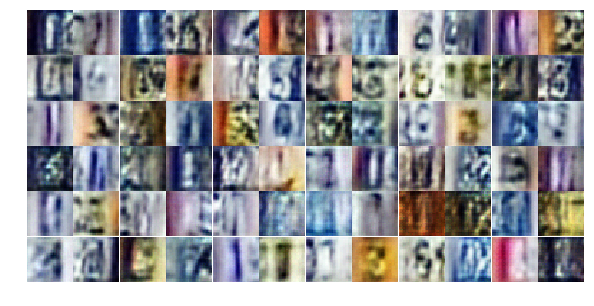

Epoch 4/25... Discriminator Loss: 1.2021... Generator Loss: 0.4954
Epoch 4/25... Discriminator Loss: 0.5931... Generator Loss: 1.7839
Epoch 4/25... Discriminator Loss: 0.5774... Generator Loss: 1.3903
Epoch 4/25... Discriminator Loss: 0.4981... Generator Loss: 1.5895
Epoch 4/25... Discriminator Loss: 0.4964... Generator Loss: 2.1952
Epoch 4/25... Discriminator Loss: 0.5378... Generator Loss: 1.3326
Epoch 4/25... Discriminator Loss: 1.2629... Generator Loss: 0.4772
Epoch 4/25... Discriminator Loss: 0.6627... Generator Loss: 1.5755
Epoch 4/25... Discriminator Loss: 0.4736... Generator Loss: 1.6085
Epoch 4/25... Discriminator Loss: 0.5759... Generator Loss: 1.2611


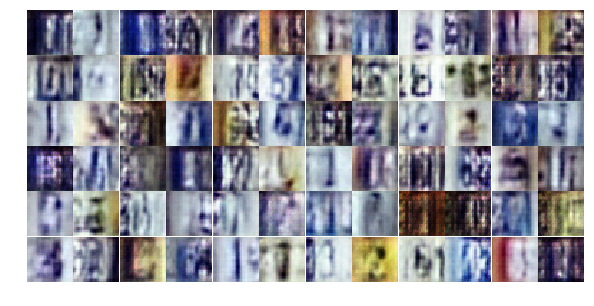

Epoch 4/25... Discriminator Loss: 0.5813... Generator Loss: 1.6040
Epoch 4/25... Discriminator Loss: 0.7945... Generator Loss: 1.3274
Epoch 4/25... Discriminator Loss: 0.3458... Generator Loss: 2.5036
Epoch 4/25... Discriminator Loss: 0.7366... Generator Loss: 1.1563
Epoch 4/25... Discriminator Loss: 0.3428... Generator Loss: 1.9237
Epoch 4/25... Discriminator Loss: 0.5593... Generator Loss: 1.7460
Epoch 4/25... Discriminator Loss: 0.5561... Generator Loss: 1.2384
Epoch 4/25... Discriminator Loss: 0.7566... Generator Loss: 1.0023
Epoch 4/25... Discriminator Loss: 0.4489... Generator Loss: 2.0721
Epoch 5/25... Discriminator Loss: 0.5408... Generator Loss: 1.8357


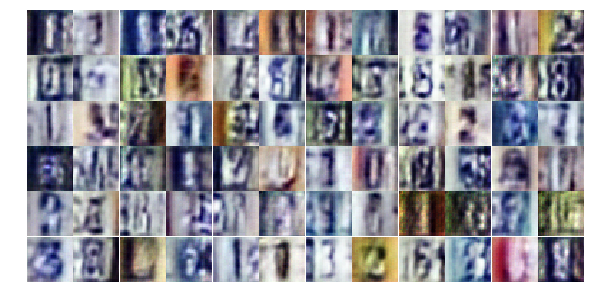

Epoch 5/25... Discriminator Loss: 0.6079... Generator Loss: 1.2139
Epoch 5/25... Discriminator Loss: 0.6868... Generator Loss: 1.0795
Epoch 5/25... Discriminator Loss: 0.5978... Generator Loss: 1.1133
Epoch 5/25... Discriminator Loss: 0.3634... Generator Loss: 1.7368
Epoch 5/25... Discriminator Loss: 0.5586... Generator Loss: 2.6354
Epoch 5/25... Discriminator Loss: 0.6665... Generator Loss: 1.1008
Epoch 5/25... Discriminator Loss: 0.7868... Generator Loss: 0.9007
Epoch 5/25... Discriminator Loss: 0.4454... Generator Loss: 1.4609
Epoch 5/25... Discriminator Loss: 0.5733... Generator Loss: 1.7164
Epoch 5/25... Discriminator Loss: 1.3893... Generator Loss: 0.3656


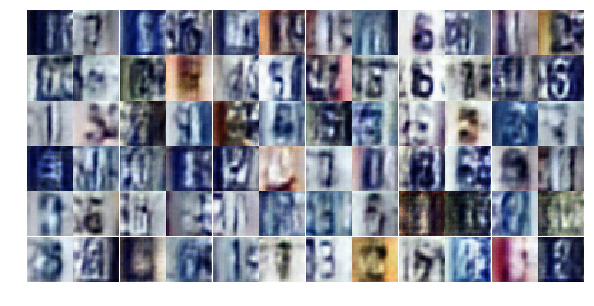

Epoch 5/25... Discriminator Loss: 0.5182... Generator Loss: 2.3161
Epoch 5/25... Discriminator Loss: 1.1587... Generator Loss: 2.4363
Epoch 5/25... Discriminator Loss: 0.3698... Generator Loss: 2.1690
Epoch 5/25... Discriminator Loss: 1.0656... Generator Loss: 0.6609
Epoch 5/25... Discriminator Loss: 1.0559... Generator Loss: 2.6197
Epoch 5/25... Discriminator Loss: 0.6734... Generator Loss: 2.4757
Epoch 5/25... Discriminator Loss: 0.5507... Generator Loss: 1.7133
Epoch 5/25... Discriminator Loss: 0.6733... Generator Loss: 1.1497
Epoch 5/25... Discriminator Loss: 0.3851... Generator Loss: 2.1708
Epoch 5/25... Discriminator Loss: 0.4474... Generator Loss: 1.5618


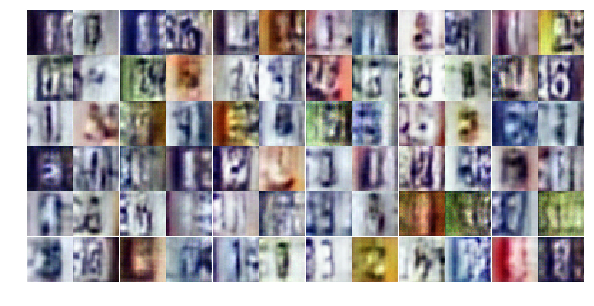

Epoch 5/25... Discriminator Loss: 0.4417... Generator Loss: 1.6334
Epoch 5/25... Discriminator Loss: 1.0990... Generator Loss: 0.6019
Epoch 5/25... Discriminator Loss: 0.6870... Generator Loss: 1.1931
Epoch 5/25... Discriminator Loss: 0.5658... Generator Loss: 1.3618
Epoch 5/25... Discriminator Loss: 1.1273... Generator Loss: 0.6038
Epoch 5/25... Discriminator Loss: 0.9212... Generator Loss: 0.7149
Epoch 5/25... Discriminator Loss: 0.7964... Generator Loss: 0.8180
Epoch 5/25... Discriminator Loss: 0.8960... Generator Loss: 0.7631
Epoch 5/25... Discriminator Loss: 0.4443... Generator Loss: 2.0082
Epoch 5/25... Discriminator Loss: 0.6631... Generator Loss: 2.2950


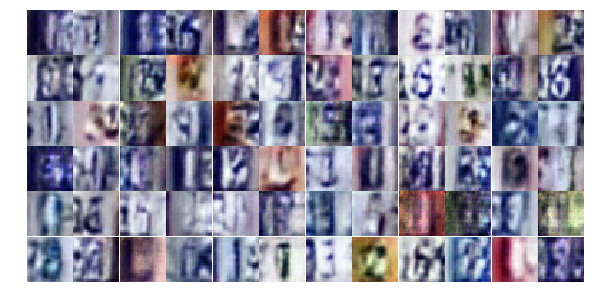

Epoch 5/25... Discriminator Loss: 0.7204... Generator Loss: 1.0407
Epoch 5/25... Discriminator Loss: 0.5370... Generator Loss: 1.3922
Epoch 5/25... Discriminator Loss: 0.5015... Generator Loss: 2.2237
Epoch 5/25... Discriminator Loss: 1.1409... Generator Loss: 0.5858
Epoch 5/25... Discriminator Loss: 0.7779... Generator Loss: 1.2934
Epoch 5/25... Discriminator Loss: 0.5300... Generator Loss: 1.8565
Epoch 5/25... Discriminator Loss: 0.6518... Generator Loss: 1.0447
Epoch 5/25... Discriminator Loss: 0.7710... Generator Loss: 0.9132
Epoch 5/25... Discriminator Loss: 0.9003... Generator Loss: 0.7738
Epoch 5/25... Discriminator Loss: 0.5111... Generator Loss: 1.4205


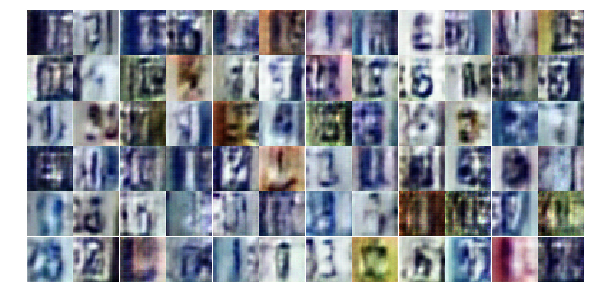

Epoch 5/25... Discriminator Loss: 0.4296... Generator Loss: 1.9075
Epoch 5/25... Discriminator Loss: 1.1928... Generator Loss: 0.5138
Epoch 5/25... Discriminator Loss: 1.5174... Generator Loss: 0.3689
Epoch 5/25... Discriminator Loss: 0.7219... Generator Loss: 1.1155
Epoch 5/25... Discriminator Loss: 0.7993... Generator Loss: 1.1333
Epoch 5/25... Discriminator Loss: 0.6808... Generator Loss: 1.7777
Epoch 5/25... Discriminator Loss: 0.6073... Generator Loss: 1.2642
Epoch 5/25... Discriminator Loss: 0.5701... Generator Loss: 1.2424
Epoch 5/25... Discriminator Loss: 0.6470... Generator Loss: 1.1054
Epoch 5/25... Discriminator Loss: 0.8454... Generator Loss: 1.6999


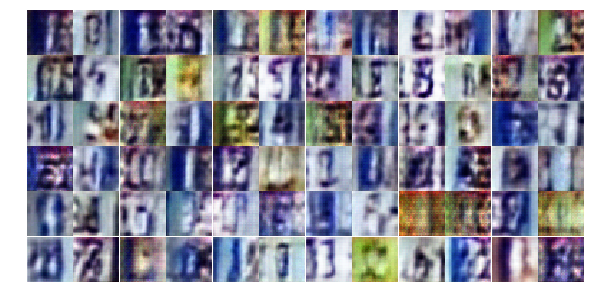

Epoch 5/25... Discriminator Loss: 2.4285... Generator Loss: 0.1357
Epoch 5/25... Discriminator Loss: 1.0464... Generator Loss: 2.2462
Epoch 5/25... Discriminator Loss: 0.9528... Generator Loss: 0.6583
Epoch 5/25... Discriminator Loss: 0.5083... Generator Loss: 1.6639
Epoch 5/25... Discriminator Loss: 0.5197... Generator Loss: 1.4194
Epoch 5/25... Discriminator Loss: 0.6820... Generator Loss: 1.2500
Epoch 6/25... Discriminator Loss: 0.5553... Generator Loss: 1.6630
Epoch 6/25... Discriminator Loss: 0.3944... Generator Loss: 1.7310
Epoch 6/25... Discriminator Loss: 0.4555... Generator Loss: 1.4620
Epoch 6/25... Discriminator Loss: 1.8237... Generator Loss: 0.2409


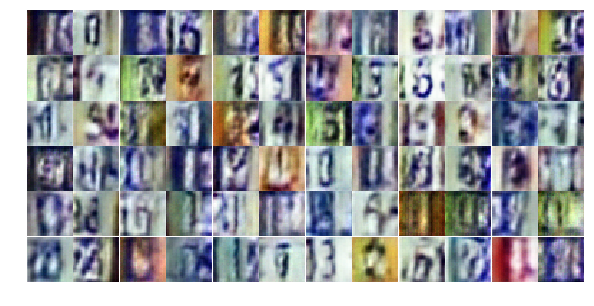

Epoch 6/25... Discriminator Loss: 0.7137... Generator Loss: 0.9368
Epoch 6/25... Discriminator Loss: 0.6349... Generator Loss: 1.1508
Epoch 6/25... Discriminator Loss: 0.8276... Generator Loss: 0.7681
Epoch 6/25... Discriminator Loss: 1.6192... Generator Loss: 0.2995
Epoch 6/25... Discriminator Loss: 0.5347... Generator Loss: 1.3835
Epoch 6/25... Discriminator Loss: 0.3702... Generator Loss: 1.7163
Epoch 6/25... Discriminator Loss: 0.4911... Generator Loss: 2.3567
Epoch 6/25... Discriminator Loss: 0.9408... Generator Loss: 0.9367
Epoch 6/25... Discriminator Loss: 0.5113... Generator Loss: 1.8396
Epoch 6/25... Discriminator Loss: 0.5000... Generator Loss: 1.7468


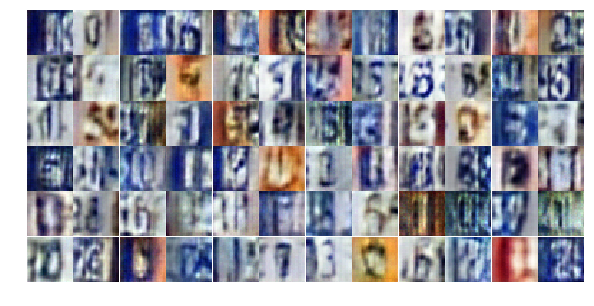

Epoch 6/25... Discriminator Loss: 0.6122... Generator Loss: 1.4316
Epoch 6/25... Discriminator Loss: 0.8759... Generator Loss: 0.7518
Epoch 6/25... Discriminator Loss: 1.2689... Generator Loss: 0.4160
Epoch 6/25... Discriminator Loss: 0.5505... Generator Loss: 1.3361
Epoch 6/25... Discriminator Loss: 0.5998... Generator Loss: 1.1392
Epoch 6/25... Discriminator Loss: 0.5854... Generator Loss: 1.9475
Epoch 6/25... Discriminator Loss: 0.5779... Generator Loss: 1.1472
Epoch 6/25... Discriminator Loss: 1.1391... Generator Loss: 0.5291
Epoch 6/25... Discriminator Loss: 1.1625... Generator Loss: 0.5374
Epoch 6/25... Discriminator Loss: 0.6074... Generator Loss: 1.2708


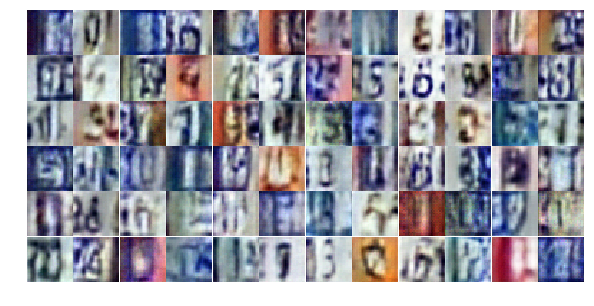

Epoch 6/25... Discriminator Loss: 1.1227... Generator Loss: 0.5472
Epoch 6/25... Discriminator Loss: 0.6946... Generator Loss: 1.9228
Epoch 6/25... Discriminator Loss: 0.7260... Generator Loss: 1.0346
Epoch 6/25... Discriminator Loss: 0.5291... Generator Loss: 1.4403
Epoch 6/25... Discriminator Loss: 0.8486... Generator Loss: 2.5414
Epoch 6/25... Discriminator Loss: 1.0801... Generator Loss: 0.6435


In [ ]:
dataset = Dataset(train_set, test_set)

losses, samples = train(net, dataset, epochs, batch_size, fig_size=(10,5))